In [110]:
# How have Airbnb rental prices changed over time (between 2008 and ?)?
# Which is the cheapest booking available per city and most expensive? VISUALIZATION (line chart, try box+whisker)
## Min (Cheapest)
## Mean (Average)
## Max (Most expensive) 
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?

In [111]:
# import modules
import os
import csv
import pandas as pd
import numpy as np
import scipy.stats as st

# import modules for visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from holoviews import opts

In [112]:
# create an Airbnb dataframe
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
airbnb_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_identity_verified,instant_bookable,accommodates,amenities,...,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,t,f,6,"[""Elevator"", ""Cable TV"", ""Air conditioning"", ""...",...,2.0,3.0,115,30,730,2,15-05-2016,0.02,1,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,t,t,1,"[""Host greets you"", ""Elevator"", ""Air condition...",...,1.0,1.0,71,30,366,27,6/10/2020,0.35,2,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,t,f,1,"[""Cooking basics"", ""Host greets you"", ""Smoke a...",...,1.0,1.0,155,1,180,21,27-12-2019,0.18,2,337
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,t,t,2,"[""Host greets you"", ""Air conditioning"", ""Carbo...",...,1.0,1.0,50,30,730,0,NaN,NaN,1,0
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,t,f,2,"[""Lock on bedroom door"", ""Fire extinguisher"", ...",...,1.0,1.0,60,30,1125,310,29-04-2020,2.25,5,337


In [113]:
# identify states
states = airbnb_df['State'].unique()
states

array(['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada',
       'New York ', 'Tennessee', 'DC', 'Washington'], dtype=object)

In [114]:
# get column names list
airbnb_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost',
       'host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'State', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'bathrooms',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

### Cleaning Data Tasks

In [116]:
# remove unnecessary columns
clean_airbnb_df = airbnb_df.drop(columns=['host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'latitude', 'longitude','room_type', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count'])

# change column names for clarity
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood_group': 'metro'})
clean_airbnb_df = clean_airbnb_df.rename(columns={'neighbourhood':'city'})

# remove host sites where availability is 0/365 days
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['availability_365'] != 0]

# remove hosts sites where price is 0
clean_airbnb_df = clean_airbnb_df[clean_airbnb_df['price'] !=0]

# change state names to abbreviations for easy visualization
# create a dictionary mapping state names to abbreviations
state_abbreviations = {
    'California': 'CA',
    'Illinois': 'IL',
    'Florida': 'FL',
    'Hawaii':'HI',
    'Nevada':'NV',
    'New York ':'NY',
    'Tennessee':'TN',
    'DC':'DC',
    'Washington':'WA'
}

# List of state names
state_names = ['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada','New York ', 'Tennessee', 'DC', 'Washington']

# Convert state names to abbreviations
states = [state_abbreviations[state] for state in state_names]

# Apply the mapping to the 'State' column
clean_airbnb_df['State Abbreviation'] = clean_airbnb_df['State'].map(state_abbreviations)

# Modify the 'Metro Area' column to include the state name after the city name
clean_airbnb_df['metro'] = clean_airbnb_df['metro'] + ', ' + clean_airbnb_df['State Abbreviation']

# Drop the 'State' column
clean_airbnb_df =clean_airbnb_df.drop(columns=['State Abbreviation'])

# reformat dates
# Ensure 'host_since' is of string type
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].astype(str)

# Now convert to datetime, allowing for multiple formats
# replace '-' with '/' in the 'host_since' column to standardize the format
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].str.replace('-', '/')
clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=False, errors='coerce')
clean_airbnb_df.head()

C:\Users\hmk81\AppData\Local\Temp\ipykernel_2152\2451254244.py:52: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], dayfirst=False, errors='coerce')


,id,name,host_id,host_name,host_since,host_is_superhost,State,metro,city,property_type,price,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,2008-06-27,f,California,"Los Angeles, CA",Culver City,Entire condominium,115,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,2008-09-16,t,California,"Los Angeles, CA",Hollywood,Private room in apartment,71,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,2008-09-17,f,California,"Los Angeles, CA",Santa Monica,Private room in apartment,155,337
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in tiny house,60,337
5,5729,Zen Room with Floating Bed near Venice and LAX,9171,Sanni,2009-03-05,t,California,"Los Angeles, CA",Del Rey,Private room in guesthouse,70,332


In [117]:
# identify metro areas represented in the data
metro_areas = clean_airbnb_df["metro"].unique()
metro_areas

array(['Los Angeles, CA', 'San Diego County, CA', 'San Francisco, CA',
       'San Mateo, CA', 'Saint Clara County, CA', ' Santa Cruz, CA',
       'Chicago, IL', 'Broward County, FL', 'Hawaii, HI', 'Kauai, HI',
       'Maui, HI', 'Honolulu, HI', 'Clark County, NV', 'Manhattan, NY',
       'Brooklyn, NY', 'Queens, NY', 'Staten Island, NY', 'Bronx, NY',
       'Nashville, TN', 'Washington D.C, DC', 'Seattle, WA'], dtype=object)

In [118]:
# average prices for each city/county (some are counties, some are cities)
# median chosen because there seemed to be some big outliers
median_prices = clean_airbnb_df.groupby('metro')['price'].median().round(2).sort_values(ascending=True)
median_prices

metro
Bronx, NY                  68.0
Queens, NY                 70.0
Staten Island, NY          76.0
Brooklyn, NY               95.0
Chicago, IL                99.0
Saint Clara County, CA     99.0
Seattle, WA               107.0
Washington D.C, DC        108.0
Los Angeles, CA           117.0
San Mateo, CA             120.0
Manhattan, NY             120.0
Broward County, FL        120.0
San Francisco, CA         129.0
Clark County, NV          129.0
San Diego County, CA      140.0
Honolulu, HI              145.0
Nashville, TN             150.0
Hawaii, HI                150.0
Maui, HI                  225.0
 Santa Cruz, CA           225.0
Kauai, HI                 239.0
Name: price, dtype: float64

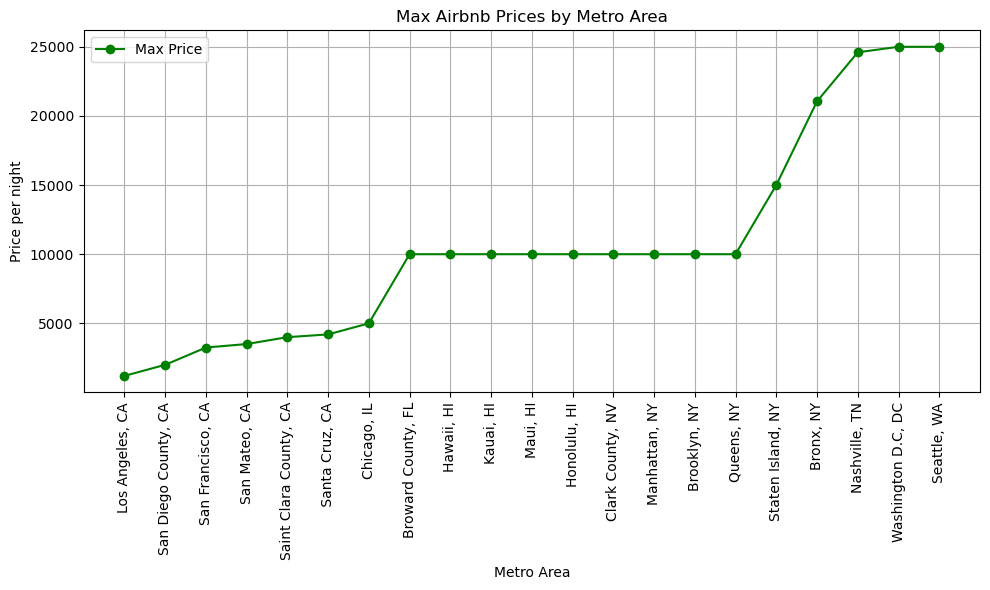

In [119]:
# visualize max values for each metro area
max_prices = clean_airbnb_df.groupby("metro")['price'].max().round(2).sort_values(ascending=True)
max_prices

x_axis = metro_areas
y_axis = max_prices

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(x_axis, y_axis, color="green", label="Max Price", marker='o')

# Add titles and labels
plt.title("Max Airbnb Prices by Metro Area")
plt.xlabel("Metro Area")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig3a.png")


In [120]:
# min values for each metro area
min_prices = clean_airbnb_df.groupby('metro')['price'].min().round(2).sort_values(ascending=True)
min_prices

metro
Washington D.C, DC        10
Brooklyn, NY              10
Chicago, IL               10
Honolulu, HI              10
Los Angeles, CA           10
San Francisco, CA         10
Nashville, TN             10
Queens, NY                10
Saint Clara County, CA    11
Broward County, FL        12
Clark County, NV          13
San Diego County, CA      13
Hawaii, HI                15
Seattle, WA               16
San Mateo, CA             19
Manhattan, NY             19
Bronx, NY                 20
Maui, HI                  20
Staten Island, NY         22
 Santa Cruz, CA           30
Kauai, HI                 49
Name: price, dtype: int64

In [121]:
# summary statistics for Airbnb prices
clean_airbnb_df["price"].describe()

count    127877.000000
mean        209.163008
std         436.704186
min          10.000000
25%          79.000000
50%         125.000000
75%         209.000000
max       24999.000000
Name: price, dtype: float64

In [122]:
# Create a data frame showing mean, min, max for each city
# Group by 'metro' and calculate mean, min, and max prices
metro_price_stats_df = pd.DataFrame(clean_airbnb_df.groupby('metro')['price'].agg(['median', 'min', 'max']))

# Reset the index to turn the grouped index into a column
metro_price_stats_df = metro_price_stats_df.reset_index()

# Rename the columns for clarity
metro_price_stats_df.columns = ['Metro Area','Median Price', 'Min Price', 'Max Price']

# Sort values by mean
# metro_price_stats_df = metro_price_stats.sort_values(by='Median Price', ascending=True)

# Display the resulting DataFrame
metro_price_stats_df

,Metro Area,Median Price,Min Price,Max Price
0,"Santa Cruz, CA",225.0,30,3250
1,"Bronx, NY",68.0,20,2000
2,"Brooklyn, NY",95.0,10,4000
3,"Broward County, FL",120.0,12,10000
4,"Chicago, IL",99.0,10,10000
5,"Clark County, NV",129.0,13,10000
6,"Hawaii, HI",150.0,15,15000
7,"Honolulu, HI",145.0,10,24600
8,"Kauai, HI",239.0,49,4200
9,"Los Angeles, CA",117.0,10,21053


Median Prices per Metro Area

In [124]:
# Take out 0 values from min price?
# worth sorting by median price?
# in original data frame, change state to abbreviation (formula for that?)

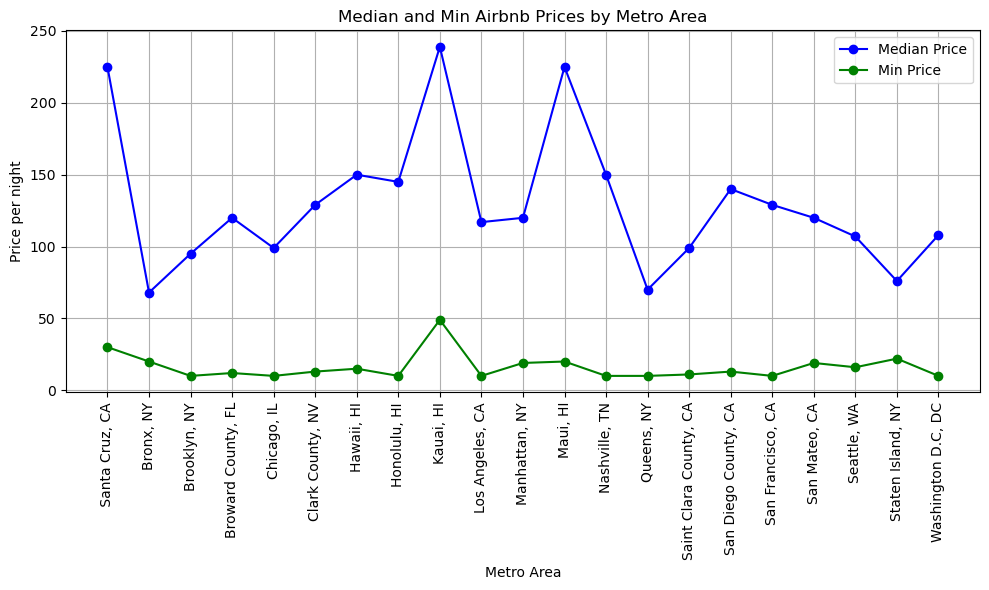

In [125]:
# create line graphs showing mean, min, and max prices for each city

# Extract the cities and corresponding prices
cities = metro_price_stats_df['Metro Area']
median_prices = metro_price_stats_df['Median Price']
min_prices = metro_price_stats_df['Min Price']
# max_prices = metro_price_stats_df['Max Price']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(cities, median_prices, color="blue", label="Median Price", marker='o')
plt.plot(cities, min_prices, color="green", label="Min Price", marker='o')
# plt.plot(cities, max_prices, color="red", label="Max Price")

# Add titles and labels
plt.title("Median and Min Airbnb Prices by Metro Area")
plt.xlabel("Metro Area")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig3b.png")

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

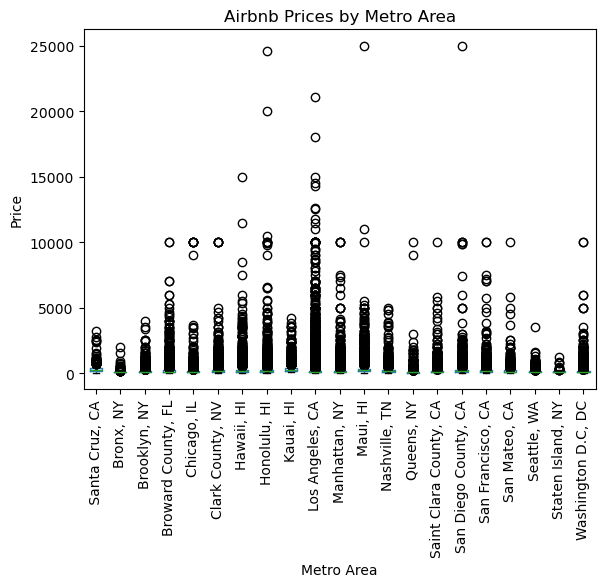

In [126]:

plt.figure(figsize=(12, 6))
clean_airbnb_df.boxplot(column='price', by='metro', grid=False)

plt.title('Airbnb Prices by Metro Area')
plt.suptitle('')  # Suppress the default title to make it cleaner
plt.xlabel('Metro Area')
plt.ylabel('Price')
plt.xticks(rotation=90)

# Save plot as image file
plt.savefig("output_data/Fig3c.png")

plt.show()

In [127]:
# For max values, identify the host_id/name - is it a hotel?

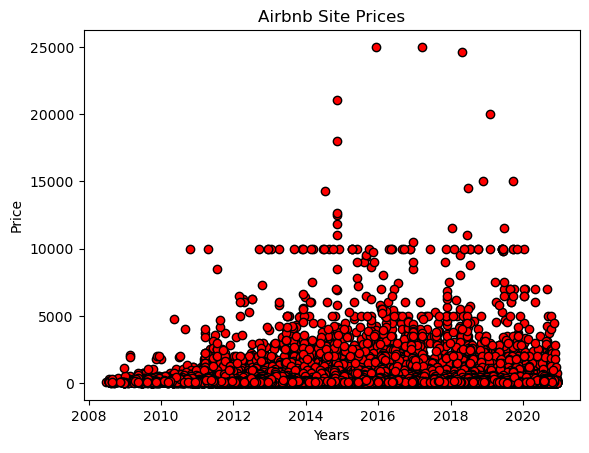

In [154]:
# price change over time (2008 to present)
clean_airbnb_df['host_since']

# scatter plot price 2008 to present
x_values = clean_airbnb_df['host_since']
y_values = clean_airbnb_df['price']
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Airbnb Site Prices') 

# Save plot as image file
plt.savefig("output_data/Fig3d.png")

plt.scatter(x_values, y_values, marker="o", facecolors="red", edgecolors = "black")

plt.show()

Text(0.5, 1.0, 'Airbnb Site Prices')

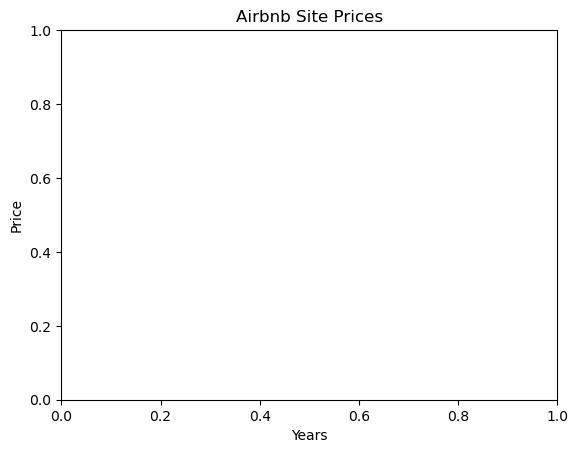

In [129]:
# median price change over time (2008 to present)
# create a new data frame location year median price

# scatter plot price 2008 to present
x_axis = clean_airbnb_df['host_since']
y_axis = clean_airbnb_df['price']
plt.xlabel('Years')
plt.ylabel('Price')
plt.title('Airbnb Site Prices') 

# plt.scatter(x_axis, y_axis, marker="o", facecolors="red", edgecolors = "black")


In [130]:
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?

In [131]:
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?